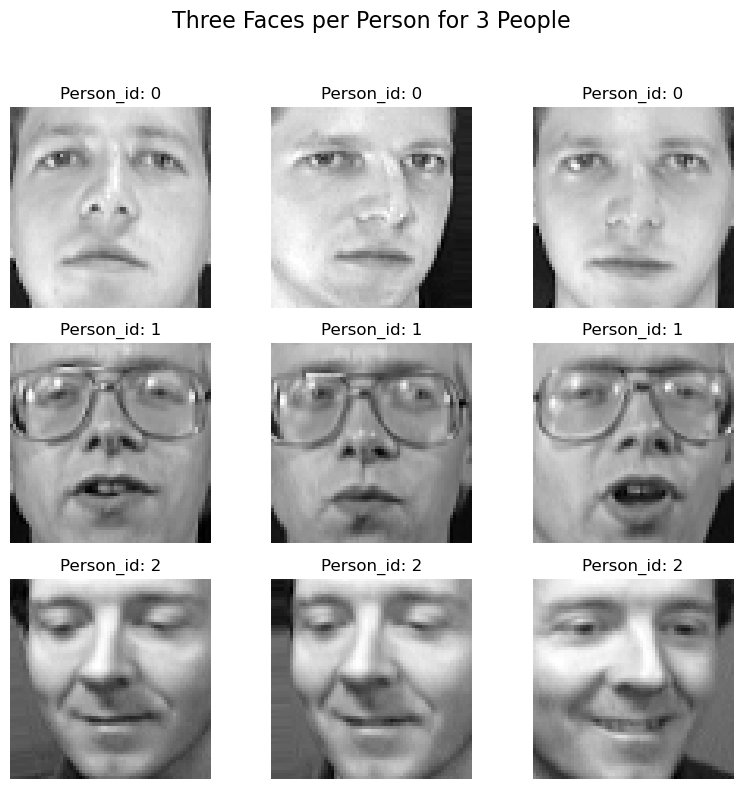

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded = torch.load("olivetti_faces_data.pth", map_location=device)
X_train = loaded['X_train']
X_test  = loaded['X_test']
y_train = loaded['y_train']
y_test  = loaded['y_test']



faces = X_train.reshape([-1,64,64])   # shape (400, 64, 64)
targets = y_train # labels from 0 to 39 (each person has 10 images)
# Select three people (e.g., persons 0, 1, and 2)
selected_people = [0, 1, 2]

# Create a subplot grid: one row per person, 3 columns (three images per person)
fig, axes = plt.subplots(nrows=len(selected_people), ncols=3, figsize=(8, 8))
fig.suptitle("Three Faces per Person for 3 People", fontsize=16)

for row, person in enumerate(selected_people):
    # Use torch.where to get indices of images for the current person
    person_indices = torch.where(targets == person)[0]
    # Select the first three indices
    selected_indices = person_indices[:3]
    for col, idx in enumerate(selected_indices):
        # Convert the face image (a torch tensor) to a NumPy array for plotting
        img = faces[idx].cpu().numpy()
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Person_id: {person}", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Part 3(a) Computing Eigenvectors and Plotting Explained Variance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


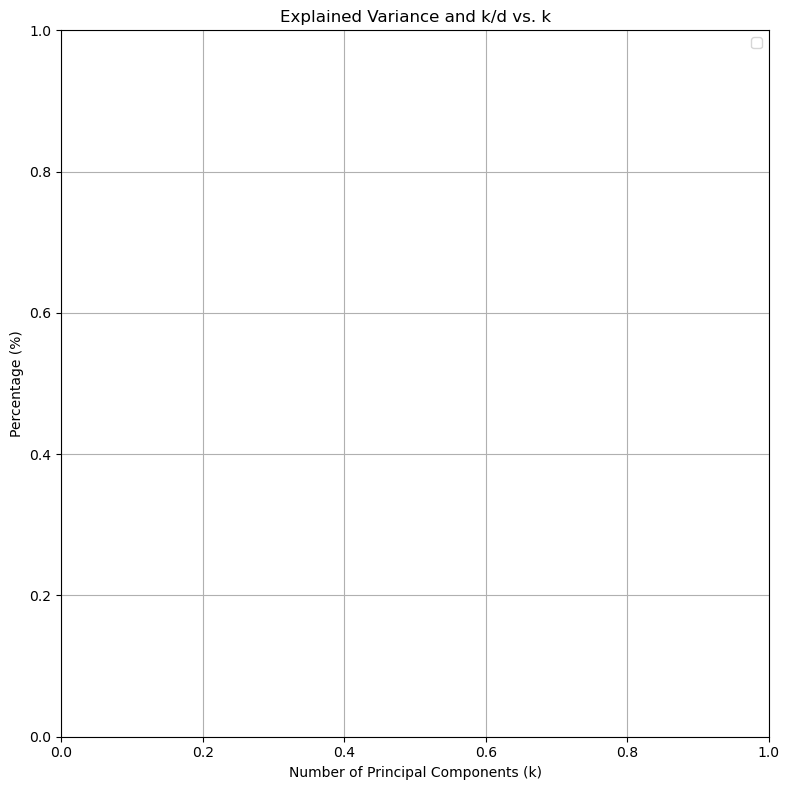

In [19]:
k_list = [1,2,4,8,16, 32,64,128,256]


# ------------------------------
# Your Code for computing PCA Here
# ------------------------------
# remember to subtract mean when computing PCA


plt.figure(figsize=(8,8))
# ------------------------------
# Plot Explained Variance vs. k and k/total_dimension curve
# ------------------------------
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Percentage (%)")
plt.title("Explained Variance and k/d vs. k")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Part 3(b) Visualizing Top-6 Eigenvectors

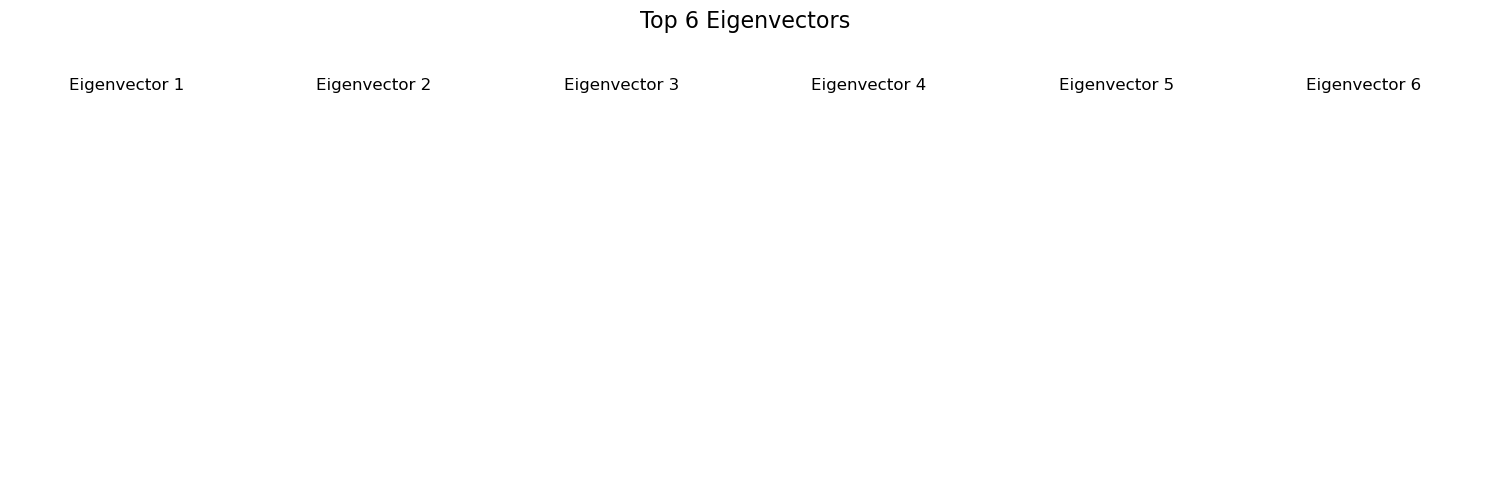

In [2]:
# Create a 1x6 grid for plotting
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
fig.suptitle("Top 6 Eigenvectors", fontsize=16)

for i in range(6):
    # ------------------------------
    # visualize eigenvector with axes[i].imshow(..., cmap='gray')
    # ------------------------------
    axes[i].axis('off')
    axes[i].set_title(f"Eigenvector {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Part 3(c) Visualizing Reconstruction with Top-k Principal Components

In [5]:
# ------------------------------
# Visualize original faces and PCA reconstructions
# ------------------------------
k_reconstruct = [10, 50, 100]

# remember to add back mean when displaying image

Part (d) Implement Logistic Regression and Train on Full Set of Features

In [6]:
# ------------------------------
# Define logistic regression model and solve (using pytorch+SGD or scikitlearn)
# remember to print your test accuracy on full dimensions.
# ------------------------------

k =   1: Explained Variance = 24.07%, k/4096 =  0.02%, Test Accuracy =  9.17%
k =   2: Explained Variance = 37.97%, k/4096 =  0.05%, Test Accuracy = 18.33%
k =   4: Explained Variance = 51.06%, k/4096 =  0.10%, Test Accuracy = 40.83%
k =   8: Explained Variance = 62.36%, k/4096 =  0.20%, Test Accuracy = 77.50%
k =  16: Explained Variance = 73.59%, k/4096 =  0.39%, Test Accuracy = 90.83%
k =  32: Explained Variance = 83.32%, k/4096 =  0.78%, Test Accuracy = 96.67%
k =  64: Explained Variance = 90.78%, k/4096 =  1.56%, Test Accuracy = 98.33%
k = 128: Explained Variance = 96.53%, k/4096 =  3.12%, Test Accuracy = 97.50%
k = 256: Explained Variance = 99.83%, k/4096 =  6.25%, Test Accuracy = 98.33%


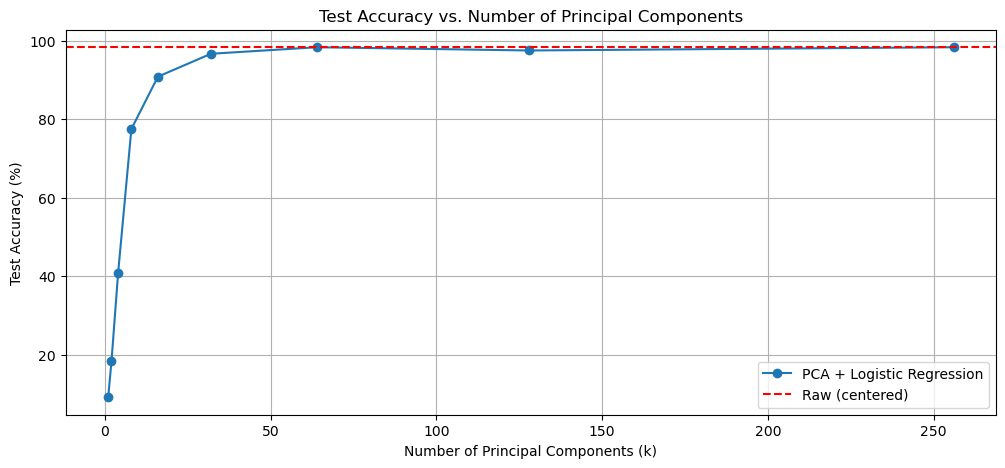

In [18]:
# ------------------------------
# PCA + Logistic Regression for different k values
# ------------------------------
k_list = [1,2,4,8,16, 32,64,128,256] # you can change this list if needed
pca_accuracies = []
explained_variances = []
k_ratios = []  # k / total_dimension (total_dimension = 4096)

for k in k_list:
    # Select top-k eigenvectors (principal components)
    pcs = eigvecs[:, :k]  # shape (4096, k)
    
    # Project centered data onto these components
    X_train_pca = X_train_centered @ pcs  # shape (n_train, k)
    X_test_pca  = X_test_centered @ pcs   # shape (n_test, k)
    
    # Compute explained variance ratio for top-k components (in percent)
    explained = torch.sum(eigvals[:k]) / total_variance
    explained_variances.append(explained.item() * 100)
    
    # Compute ratio of k to total dimension (as percent)
    k_ratios.append((k / X_train_centered.shape[1]) * 100)
    
    # Train logistic regression on PCA-reduced data
    model_pca = LogisticRegression(input_dim=k, num_classes=num_classes).to(device)
    accuracy_pca = train_model(model_pca, X_train_pca, y_train, X_test_pca, y_test)
    pca_accuracies.append(accuracy_pca)
    
    print(f"k = {k:3d}: Explained Variance = {explained.item()*100:5.2f}%, k/4096 = {k/4096*100:5.2f}%, Test Accuracy = {accuracy_pca:5.2f}%")

# ------------------------------
# Plot Test Accuracy and Explained Variance vs. k
# ------------------------------
plt.figure(figsize=(12, 5))

# Plot Test Accuracy vs. k
plt.plot(k_list, pca_accuracies, marker='o', label='PCA + Logistic Regression')
plt.axhline(y=accuracy_raw, color='red', linestyle='--', label='Raw (centered)')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs. Number of Principal Components")
plt.legend()
plt.grid(True)

plt.show()

